In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

In [ ]:
import json
import pickle
import os
import numpy as np
import proplot as pplt
import networkx as nx
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

COLORS = []
colors = pplt.Cycle('ggplot')
for color in colors:
    COLORS.append(color['color'])
colors = pplt.Cycle('default')
for color in colors:
    COLORS.append(color['color'])

COLORS[0], COLORS[1] = COLORS[1], COLORS[0]

    
pplt.rc['figure.facecolor'] = 'white'

RESULT_DIR = "../../mpcd_result/"
DATA_DIR    = "../../mpcd/result_1106/"
FIGURE_DIR = "../../mpcd_figure/"

with open('plot_style.json', 'r') as f:
    format_params = json.load(f)
    
MOMENTS    = np.array([0.1, 0.08, 0.006, 0.04, 0.030, 0.024, 0.018, 0.012, 
                    0.006, 0.003, 0.001, 0.0008, 0.0006, 0.0004])

def format_ax(ax):
    ax.format(**format_params)
    ax.tick_params(top=True, right=True, bottom=True, left=True, which='both')
    ax.minorticks_on()

In [ ]:
from cg_topo_solv.analysis.result import load_target, load_all_fit, get_meta_counts
from cg_topo_solv.plot.plot_graph import plot_graph
from cg_topo_solv.analysis.visc import calc_viscosity, process_viscosity_data

format_params_update = {
    'xscale': 'log',
    'xlim': [5e-5, 5e-2],
    'ylim': [3.8, 5.4],
    'xticks': [1e-4, 1e-3, 1e-2],
    'yticks': [3.8, 4.2, 4.6, 5.0, 5.4],
    'xticklabels': [r'$10^{-4}$', r'$10^{-3}$', r'$10^{-2}$'],
    'xlabel': r'Shear Rate $\dot{\mathit{\gamma}}~[(\mathit{m}\mathit{\sigma}^2/\mathit{\epsilon})^{-1/2}]$',
    'ylabel': r'Shear Viscosity $\mathit{\eta}~[(\mathit{m}\mathit{\epsilon})^{1/2}/\mathit{\sigma}^2]$',
}


def is_path_graph(G):
    return nx.is_tree(G) and max(dict(G.degree()).values()) <= 2

In [14]:
hi_idx, mid_idx, lo_idx, target_curves, target_labels, target_params = load_target(RESULT_DIR, verbose=False)
all_descriptors, all_params, all_curves, shear_rates, all_graphs = load_all_fit(RESULT_DIR, rerun=False)

In [74]:
hi_file = os.path.join(RESULT_DIR, "extrapolation_hi_result.pickle")
mid_file = os.path.join(RESULT_DIR, "extrapolation_mid_result.pickle")

hi_dir = os.path.join(DATA_DIR, "extrapolation_hi_v2")
mid_dir = os.path.join(DATA_DIR, "extrapolation_mid_v2")

def get_extrapolated_curves(data_dir, save_path, rerun=False):
    if rerun or not os.path.exists(save_path):
        meta = get_meta_counts(data_dir)
        meta = dict(sorted(meta.items(), key=lambda x: (int(x[0].split('_')[0]), int(x[0].split('_')[1]), float(x[0].split('_')[-1]))))

        print(meta)
        
        curves = []
        for m in tqdm(meta, total=len(meta)):
            result = calc_viscosity(
                data_dir=data_dir,
                meta="*" + m + "*",
                num_samples=100,
                size=120,
                valid_moments=MOMENTS,
                verbose=1
            )
            _, xs, ys, params = process_viscosity_data(result)
            curves.append(ys)
        curves = np.array(curves)
        with open(save_path, "wb") as f:
            pickle.dump(curves, f)
    else:
        with open(save_path, "rb") as f:
            curves = pickle.load(f)
    return curves

hi_curves = get_extrapolated_curves(hi_dir, hi_file, rerun=False)
mid_curves = get_extrapolated_curves(mid_dir, mid_file, rerun=False)

target_idx = np.concatenate((lo_idx, mid_idx, hi_idx))
target_ordered = target_curves[target_idx]

base_curves = np.concatenate((all_curves[:30], all_curves[-150:]), axis=0)

explored_hi = np.concatenate((base_curves, hi_curves), axis=0)
mae_hi = np.mean((explored_hi[None, :, :] - target_ordered[:, None, :]) ** 2, axis=2)
mae_hi_base = np.mean((base_curves[None, :, :] - target_ordered[:, None, :]) ** 2, axis=2)

explored_mid = np.concatenate((base_curves, mid_curves), axis=0)
mae_mid = np.mean((explored_mid[None, :, :] - target_ordered[:, None, :]) ** 2, axis=2)
mae_mid_base = np.mean((base_curves[None, :, :] - target_ordered[:, None, :]) ** 2, axis=2)

Plotting hi curves: 100%|██████████| 10/10 [00:00<00:00, 24.32it/s]


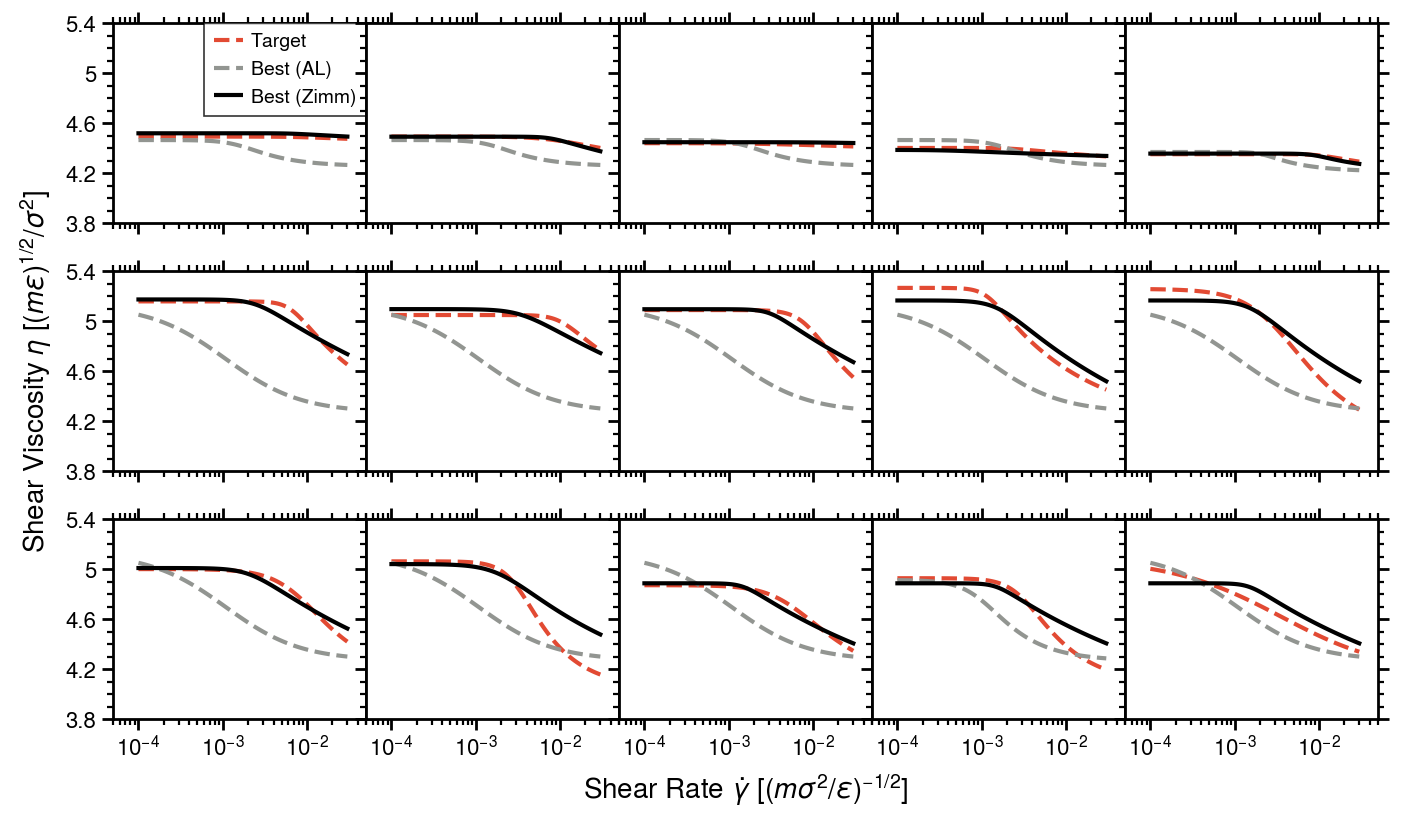

In [75]:
format_params_update = {
    'xscale': 'log',
    'xlim': [5e-5, 5e-2],
    'ylim': [3.8, 5.4],
    'xticks': [1e-4, 1e-3, 1e-2],
    'yticks': [3.8, 4.2, 4.6, 5.0, 5.4],
    'xticklabels': [r'$10^{-4}$', r'$10^{-3}$', r'$10^{-2}$'],
    'xlabel': r'Shear Rate $\dot{\mathit{\gamma}}~[(\mathit{m}\mathit{\sigma}^2/\mathit{\epsilon})^{-1/2}]$',
    'ylabel': r'Shear Viscosity $\mathit{\eta}~[(\mathit{m}\mathit{\epsilon})^{1/2}/\mathit{\sigma}^2]$',
}

plot_idx_mid = [10, 11, 12, 13, 15]
plot_idx_hi = list(range(20, 30))

fig, ax = pplt.subplots(ncols=5, nrows=3, journal="pnas3", refheight=1, share=True, wspace=0.0)

for i in tqdm(range(5), desc="Plotting mid curves"):
    target = target_ordered[plot_idx_mid[i]]
    
    mae_all = np.mean(np.square(explored_mid - target), axis=1)
    mae_base = np.mean(np.square(base_curves - target), axis=1)

    idx_all = np.argmin(mae_all)
    idx_base = np.argmin(mae_base)
        
    ax[i].plot(shear_rates[0], target, '--', c=COLORS[1], alpha=1.0, zorder=2, label="Target")
    ax[i].plot(shear_rates[0], base_curves[idx_base], 'gray', linestyle="--", zorder=3, label="Best (AL)")
    ax[i].plot(shear_rates[0], explored_mid[idx_all], 'k', zorder=3, label="Best (Zimm)")

    ax[i].tick_params(top=True, right=True, bottom=True, left=True, which='both')
    ax[i].minorticks_on()
    ax[i].grid()
    ax[i].format(**format_params_update)
    format_ax(ax[i])

    if i == 0:
        ax[i].legend(loc="upper right", prop={"size": 7}, ncol=1, handlelength=1.5, handletextpad=0.4)

for i in tqdm(range(10), desc="Plotting hi curves"):
    target = target_ordered[plot_idx_hi[i]]

    mae_all = np.mean(np.square(explored_hi - target), axis=1)
    mae_base = np.mean(np.square(base_curves - target), axis=1)

    idx_all = np.argmin(mae_all)
    idx_base = np.argmin(mae_base)

    ax[i + 5].plot(shear_rates[0], target, '--', c=COLORS[1], alpha=1.0, zorder=2)
    ax[i + 5].plot(shear_rates[0], base_curves[idx_base], 'gray', linestyle="--", zorder=3)
    ax[i + 5].plot(shear_rates[0], explored_hi[idx_all], 'k', zorder=3)

    ax[i + 5].tick_params(top=True, right=True, bottom=True, left=True, which='both')
    ax[i + 5].minorticks_on()
    ax[i + 5].grid()
    ax[i + 5].format(**format_params_update)
    format_ax(ax[i + 5])

fig.save(FIGURE_DIR + "curve_all_tuned.svg", background="white", bbox_inches="tight", dpi=300)

In [76]:
mid_sample_path = os.path.join(RESULT_DIR, "extrapolation_mid_samples.pickle")
hi_sample_path = os.path.join(RESULT_DIR, "extrapolation_hi_samples.pickle")

with open(mid_sample_path, "rb") as handle:
    mid_graphs_1 = pickle.load(handle)
    mid_descs_1 = pickle.load(handle)
    mid_graphs_2 = pickle.load(handle)
    mid_descs_2 = pickle.load(handle)

with open(hi_sample_path, "rb") as handle:
    hi_graphs_1 = pickle.load(handle)
    hi_descs_1 = pickle.load(handle)
    hi_graphs_2 = pickle.load(handle)
    hi_descs_2 = pickle.load(handle)

Plotting mid curves:  20%|██        | 1/5 [00:00<00:00,  4.16it/s]

2_3_0.0073_meta_120_120_120_0.0800
3_4_0.3895_meta_120_120_120_0.0600


Plotting mid curves:  60%|██████    | 3/5 [00:00<00:00,  4.20it/s]

2_3_0.0073_meta_120_120_120_0.0700


Plotting mid curves:  80%|████████  | 4/5 [00:00<00:00,  4.40it/s]

3_4_0.3895_meta_120_120_120_0.0500


Plotting mid curves: 100%|██████████| 5/5 [00:01<00:00,  4.24it/s]


3_2_0.3918_meta_120_120_120_0.0500


Plotting hi curves:   0%|          | 0/10 [00:00<?, ?it/s]

3_6_0.0225_meta_120_120_120_0.0900


Plotting hi curves:  10%|█         | 1/10 [00:00<00:02,  4.15it/s]

3_0_0.0086_meta_120_120_120_0.0900


Plotting hi curves:  20%|██        | 2/10 [00:00<00:01,  4.16it/s]

3_7_0.0480_meta_120_120_120_0.0900


Plotting hi curves:  30%|███       | 3/10 [00:00<00:01,  4.13it/s]

2_1_0.0250_meta_120_120_120_0.0600


Plotting hi curves:  40%|████      | 4/10 [00:00<00:01,  3.96it/s]

2_1_0.0250_meta_120_120_120_0.0600


Plotting hi curves:  50%|█████     | 5/10 [00:01<00:01,  3.90it/s]

2_4_0.0129_meta_120_120_120_0.0600


Plotting hi curves:  60%|██████    | 6/10 [00:01<00:01,  3.93it/s]

2_7_0.0480_meta_120_120_120_0.0600


Plotting hi curves:  70%|███████   | 7/10 [00:01<00:00,  3.73it/s]

2_6_0.0225_meta_120_120_120_0.0500


Plotting hi curves:  80%|████████  | 8/10 [00:02<00:00,  3.85it/s]

2_6_0.0225_meta_120_120_120_0.0500


Plotting hi curves:  90%|█████████ | 9/10 [00:02<00:00,  3.86it/s]

2_6_0.0225_meta_120_120_120_0.0500


Plotting hi curves: 100%|██████████| 10/10 [00:02<00:00,  3.92it/s]


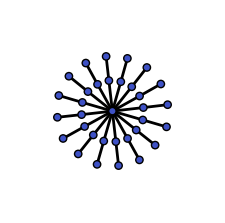

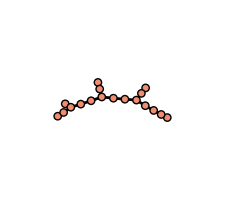

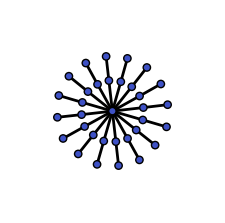

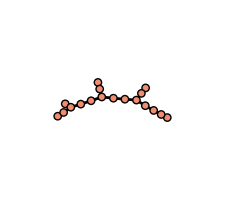

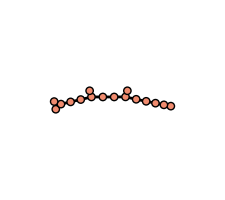

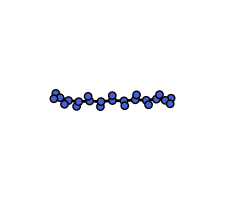

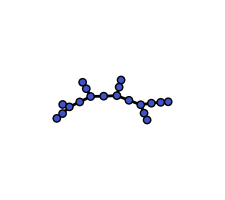

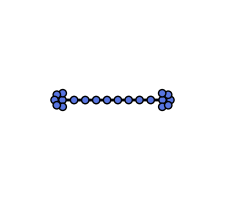

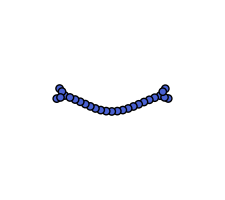

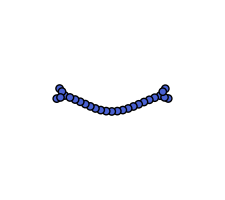

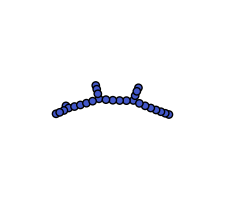

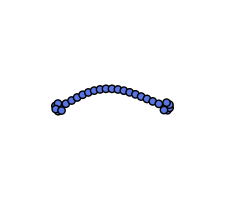

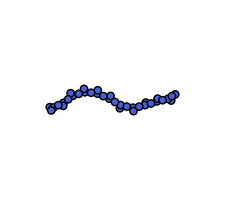

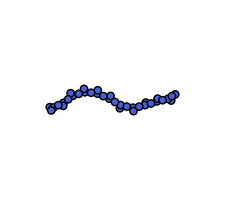

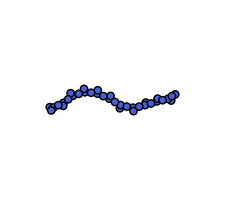

In [78]:
plot_idx_mid = [10, 11, 12, 13, 15]
plot_idx_hi = list(range(20, 30))

for i in tqdm(range(5), desc="Plotting mid curves"):
    target = target_ordered[plot_idx_mid[i]]
    
    mae_all = np.mean(np.square(explored_mid - target), axis=1)
    mae_base = np.mean(np.square(base_curves - target), axis=1)

    idx_all = np.argmin(mae_all)
    idx_base = np.argmin(mae_base)
        
    meta = get_meta_counts(mid_dir)
    meta = dict(sorted(meta.items(), key=lambda x: (int(x[0].split('_')[0]), int(x[0].split('_')[1]), float(x[0].split('_')[-1]))))

    meta_temp = list(meta.keys())[idx_all-180]

    if int(meta_temp[0]) == 2:
        graph_temp = mid_graphs_1
        desc_temp = mid_descs_1
    elif int(meta_temp[0]) == 3:
        graph_temp = mid_graphs_2
        desc_temp = mid_descs_2

    idx_temp = int(meta_temp[2])

    fig, ax = pplt.subplots(refwidth=1, refheight=1)
    plot_graph(graph_temp[idx_temp], ax, desc_temp[idx_temp][-1], node_size=7, iteration=200)
    print(meta_temp)
    fig.save(FIGURE_DIR + f"extra3/mid_{i}_{meta_temp}_v2.svg", background="transparent", transparent=True, bbox_inches="tight")

for i in tqdm(range(10), desc="Plotting hi curves"):
    target = target_ordered[plot_idx_hi[i]]

    mae_all = np.mean(np.square(explored_hi - target), axis=1)
    mae_base = np.mean(np.square(base_curves - target), axis=1)

    idx_all = np.argmin(mae_all)
    idx_base = np.argmin(mae_base)
        
    meta = get_meta_counts(hi_dir)
    meta = dict(sorted(meta.items(), key=lambda x: (int(x[0].split('_')[0]), int(x[0].split('_')[1]), float(x[0].split('_')[-1]))))
    
    meta_temp = list(meta.keys())[idx_all-180]

    if int(meta_temp[0]) == 2:
        graph_temp = hi_graphs_1
        desc_temp = hi_descs_1
    elif int(meta_temp[0]) == 3:
        graph_temp = hi_graphs_2
        desc_temp = hi_descs_2

    idx_temp = int(meta_temp[2])
    print(meta_temp)

    fig, ax = pplt.subplots(refwidth=1, refheight=1)
    plot_graph(graph_temp[idx_temp], ax, desc_temp[idx_temp][-1], node_size=7, iteration=200)